<a href="https://colab.research.google.com/github/adithyaroy99/Time-Series-Forecasting-Store-Sales-Favorita/blob/main/store_sales_time_series_forecasting_kaggle_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import (train_test_split, TimeSeriesSplit, RandomizedSearchCV, learning_curve)
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [ ]:
# Load dataset
stores = pd.read_csv('/content/stores.csv')
oil = pd.read_csv('/content/oil.csv', parse_dates=['date'])
holidays = pd.read_csv('/content/holidays_events.csv', parse_dates=['date'])
transactions = pd.read_csv('/content/transactions.csv', parse_dates=['date'])
train = pd.read_csv('/content/train.csv', parse_dates=['date'])

In [ ]:
## Data Preprocessing

In [ ]:
# Change column names that are similar but represents a different feature
stores.rename(columns={'type': 'store_type'}, inplace=True)
holidays.rename(columns={'type': 'holiday_type'}, inplace=True)

In [ ]:
# Merge datasets
data = train.merge(stores, on = 'store_nbr', how='left')
data = data.merge(oil, on = 'date', how='left')

# Merge with holidays (only non-transferred holidays)
holidays = holidays[holidays['transferred'] == False]
data = data.merge(holidays[['date', 'holiday_type', 'locale']], on='date', how='left')
data['is_holiday'] = data['holiday_type'].notnull().astype(int)

data = data.merge(transactions, on = ['date', 'store_nbr'], how='left')

data.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,dcoilwtico,holiday_type,locale,is_holiday,transactions
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,1,NaN
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,1,NaN
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,1,NaN
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,1,NaN
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,1,NaN


In [ ]:
# Display basic information about the combined dataset
print("\nData Info:")
print(data.info())

# Summary statistics
print("\nSummary Statistics:")
pd.options.display.float_format = '{:f}'.format
print(data.describe())


Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3054348 entries, 0 to 3054347
Data columns (total 15 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            int64         
 1   date          datetime64[ns]
 2   store_nbr     int64         
 3   family        object        
 4   sales         float64       
 5   onpromotion   int64         
 6   city          object        
 7   state         object        
 8   store_type    object        
 9   cluster       int64         
 10  dcoilwtico    float64       
 11  holiday_type  object        
 12  locale        object        
 13  is_holiday    int64         
 14  transactions  float64       
dtypes: datetime64[ns](1), float64(3), int64(5), object(6)
memory usage: 349.5+ MB
None

Summary Statistics:
                  id                           date      store_nbr  \
count 3054348.000000                        3054348 3054348.000000   
mean  1504276.775379  2015-04-26 12:11:45.717619

In [ ]:
# Check for missing values
print("\nMissing values:")
print(data.isnull().sum())

# Check date range
print("\nDate range:")
print("From:", data['date'].min())
print("To:", data['date'].max())


Missing values:
id                    0
date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
city                  0
state                 0
store_type            0
cluster               0
dcoilwtico       955152
holiday_type    2567862
locale          2567862
is_holiday            0
transactions     249117
dtype: int64

Date range:
From: 2013-01-01 00:00:00
To: 2017-08-15 00:00:00


In [ ]:
data.shape

(3054348, 15)

In [ ]:
## Handle missing values
data.fillna({
    'holiday_type': 'Work Day',
    'transactions' : 0,
    'locale'       : 'No Holiday'
}, inplace=True)

# Interpolate missing oil prices
data['dcoilwtico'] = data['dcoilwtico'].interpolate(method='linear', limit_direction='both')

In [ ]:
# Create time-based features
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day_of_week'] = data['date'].dt.dayofweek
data['is_weekend'] = data['day_of_week'].isin([5, 6]).astype(int)

In [ ]:
# Feature Engineering: Store×Family lag & rolling‐window statistics
group_cols = ['store_nbr', 'family']
g = data.groupby(group_cols)['sales']

# Create lag and rolling features (all lagged by 1 day):
#   • lag_1         = sales on the previous day
#   • roll_mean_7   = 7-day moving average of sales
#   • roll_std_7    = 7-day moving standard deviation of sales
data['lag_1']        = g.transform(lambda x: x.shift(1))
data['roll_mean_7']  = g.transform(lambda x: x.shift(1).rolling(window=7).mean())
data['roll_std_7']   = g.transform(lambda x: x.shift(1).rolling(window=7).std())

# Drop rows where any of the new features are NaN (i.e. the first few days per group)
data = data.dropna(subset=['lag_1', 'roll_mean_7', 'roll_std_7']) \
           .reset_index(drop=True)

print("After lag/rolling feature creation, data shape:", data.shape)

After lag/rolling feature creation, data shape: (3041874, 22)


In [ ]:
data.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,...,locale,is_holiday,transactions,year,month,day_of_week,is_weekend,lag_1,roll_mean_7,roll_std_7
0,12474,2013-01-08,1,AUTOMOTIVE,2.000000,0,Quito,Pichincha,D,13,...,No Holiday,0,1869.000000,2013,1,1,0,0.000000,2.142857,1.772811
1,12475,2013-01-08,1,BABY CARE,0.000000,0,Quito,Pichincha,D,13,...,No Holiday,0,1869.000000,2013,1,1,0,0.000000,0.000000,0.000000
2,12476,2013-01-08,1,BEAUTY,3.000000,0,Quito,Pichincha,D,13,...,No Holiday,0,1869.000000,2013,1,1,0,1.000000,1.285714,1.380131
3,12477,2013-01-08,1,BEVERAGES,1029.000000,0,Quito,Pichincha,D,13,...,No Holiday,0,1869.000000,2013,1,1,0,1158.000000,812.571429,442.221233
4,12478,2013-01-08,1,BOOKS,0.000000,0,Quito,Pichincha,D,13,...,No Holiday,0,1869.000000,2013,1,1,0,0.000000,0.000000,0.000000


In [ ]:
# Configure matplotlib for nicer defaults
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["font.size"] = 12

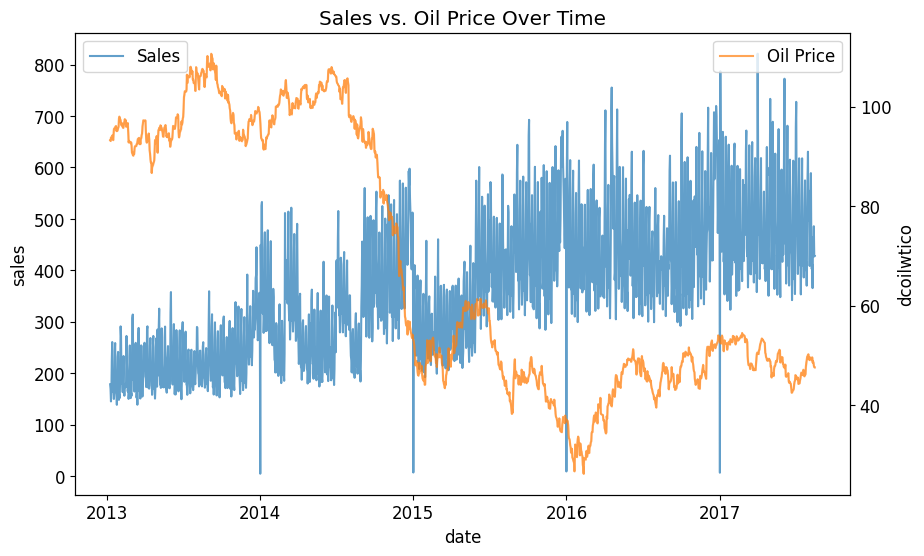

In [ ]:
# Oil Price vs. Sales (Line Chart)
sns.lineplot(data=data, x='date', y='sales', color='tab:blue', label='Sales', alpha=0.7, errorbar=None)
ax2 = plt.gca().twinx() # Get the current axes and create a twin
sns.lineplot(data=data, x='date', y='dcoilwtico', color='tab:orange', label='Oil Price', alpha=0.7, ax=ax2)
plt.title('Sales vs. Oil Price Over Time')
plt.show()

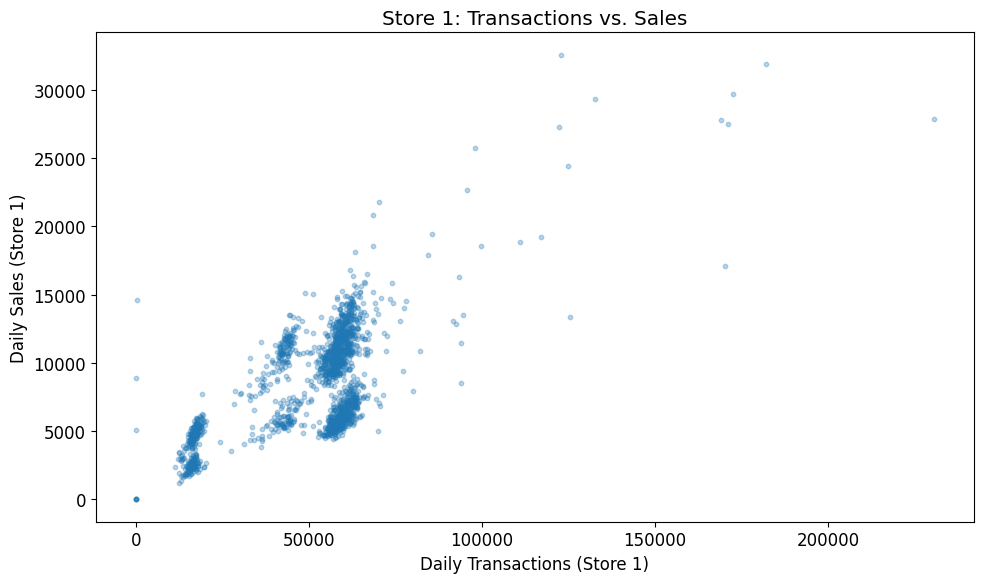

In [ ]:
# Transactions vs. Sales (Example: Store #1, to see how transaction volume translates to revenue)
store_id = 1
store_sales = data[data['store_nbr'] == store_id].groupby('date')['sales'].sum().reset_index()
store_trans = data[data['store_nbr'] == store_id].groupby('date')['transactions'].sum().reset_index()

store_merged = store_sales.merge(store_trans, on='date', how='left').fillna(0)

plt.scatter(store_merged['transactions'], store_merged['sales'], alpha=0.3, s=10)
plt.xlabel(f'Daily Transactions (Store {store_id})')
plt.ylabel(f'Daily Sales (Store {store_id})')
plt.title(f'Store {store_id}: Transactions vs. Sales')
plt.tight_layout()
plt.show()

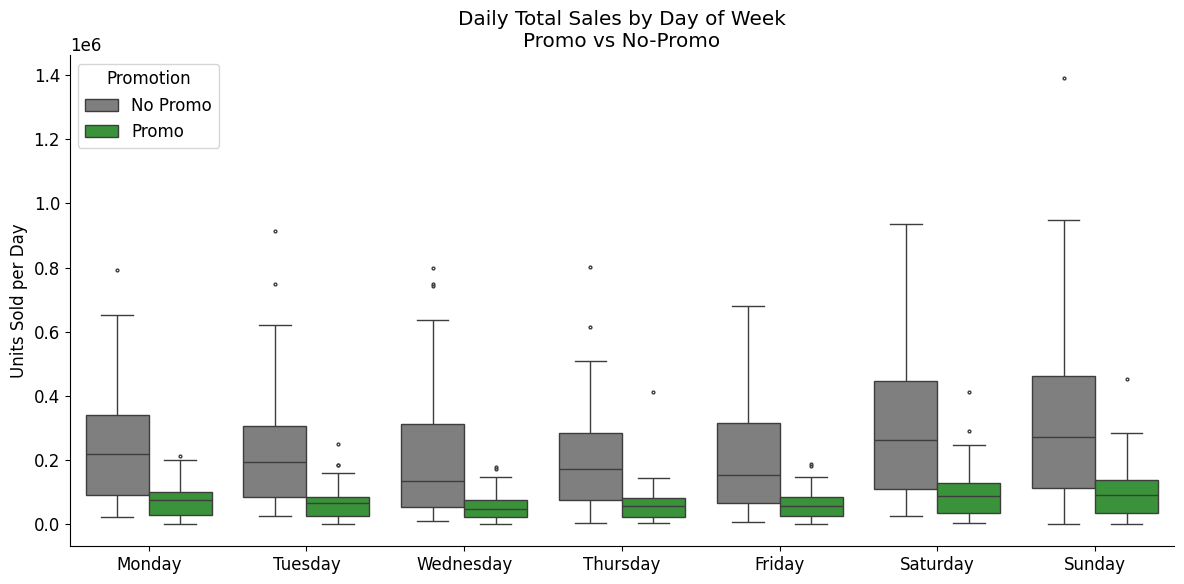

In [ ]:
# Promotions affect daily sales
# Prepare a daily‐total table with promo flag
daily_promo = (
    data
    .groupby(['date','onpromotion'])['sales']
    .sum()
    .reset_index()
    .rename(columns={'onpromotion':'promo_flag'})
)
# add human‐readable columns
daily_promo['day_name'] = daily_promo['date'].dt.day_name()
daily_promo['promo_flag'] = daily_promo['promo_flag'].map({0:'No Promo', 1:'Promo'})

# Define order & palette
order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
palette = {'No Promo':'tab:gray','Promo':'tab:green'}

# Draw
plt.figure(figsize=(12,6))
sns.boxplot(
    data=daily_promo,
    x='day_name', y='sales', hue='promo_flag',
    order=order, palette=palette,
    fliersize=2,      # tiny dots for outliers
    linewidth=1
)

# Tidy up
plt.title('Daily Total Sales by Day of Week\nPromo vs No-Promo')
plt.xlabel('')
plt.ylabel('Units Sold per Day')
#plt.xticks(rotation=45)
plt.legend(title='Promotion', loc='upper left')
sns.despine(left=False, bottom=False)
plt.tight_layout()
plt.show()


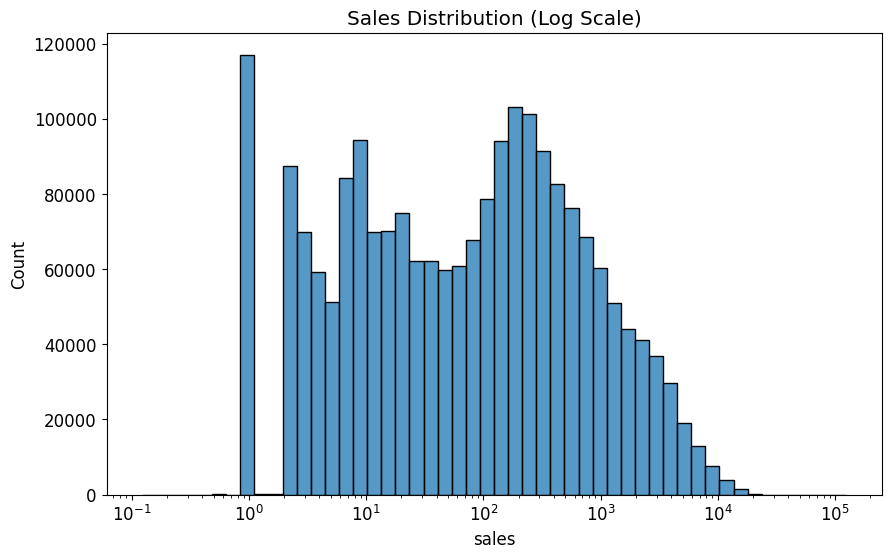

In [ ]:
# Sales Distribution (Histogram)
# To check the distribution of sales and identify outliers

sns.histplot(data=data, x='sales', bins=50, log_scale=True)
plt.title('Sales Distribution (Log Scale)')
plt.show()

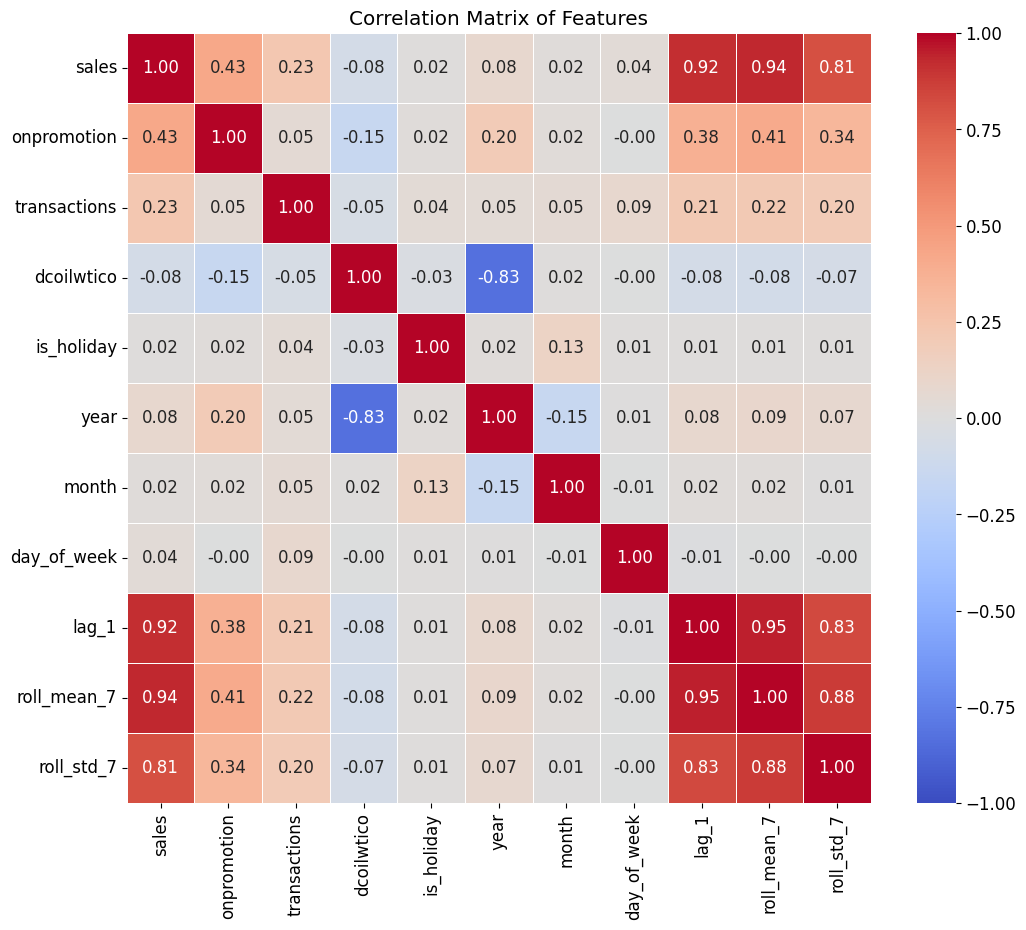

In [ ]:
# Correlation Heatmap of Numerical Features

# Select only numeric features

corr_cols = [
    'sales', 'onpromotion', 'transactions', 'dcoilwtico', 'is_holiday',
    'year', 'month', 'day_of_week',
    'lag_1', 'roll_mean_7', 'roll_std_7'
]
corr_matrix = data[corr_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    vmin=-1, vmax=1,
    linewidths=0.5
)
plt.title('Correlation Matrix of Features')
plt.show()

In [ ]:
# Drop non-informative & redundant features
#    • id, date: identifiers, not inputs
#    • is_weekend: redundant with day_of_week
to_drop = ['id', 'date', 'is_weekend']
data = data.drop(columns=to_drop)
data.select_dtypes(include='object').columns

Index(['family', 'city', 'state', 'store_type', 'holiday_type', 'locale'], dtype='object')

In [ ]:
# Encode categorical columns
label_enc = LabelEncoder()
for col in data.select_dtypes(include='object').columns:
    data[col] = label_enc.fit_transform(data[col].astype(str))

data.head()

,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,dcoilwtico,holiday_type,locale,is_holiday,transactions,year,month,day_of_week,lag_1,roll_mean_7,roll_std_7
0,1,0,2.000000,0,18,12,3,13,93.210000,5,2,0,1869.000000,2013,1,1,0.000000,2.142857,1.772811
1,1,1,0.000000,0,18,12,3,13,93.210000,5,2,0,1869.000000,2013,1,1,0.000000,0.000000,0.000000
2,1,2,3.000000,0,18,12,3,13,93.210000,5,2,0,1869.000000,2013,1,1,1.000000,1.285714,1.380131
3,1,3,1029.000000,0,18,12,3,13,93.210000,5,2,0,1869.000000,2013,1,1,1158.000000,812.571429,442.221233
4,1,4,0.000000,0,18,12,3,13,93.210000,5,2,0,1869.000000,2013,1,1,0.000000,0.000000,0.000000


In [ ]:
# Take a random sample of the data
sample_frac = 0.10   # 10% sample → ~300 K rows; try 0.05 or 0.20 as you like
data_sample = data.sample(frac=sample_frac, random_state=42).reset_index(drop=True)
print("Sampled data shape:", data_sample.shape)

Sampled data shape: (304187, 19)


In [ ]:
# Regression Model Development and Evaluation
# Prepare data for modeling
X = data_sample.drop('sales', axis=1)
y = data_sample['sales']

In [ ]:
# Split data into train (60%), validation (20%), and test (20%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
# Normalize features
num_cols = X.select_dtypes(include=['int64','float64','int32']).columns.tolist()
scaler_features = StandardScaler()
X_train = scaler_features.fit_transform(X_train[num_cols])
X_test = scaler_features.transform(X_test[num_cols])
X_val = scaler_features.transform(X_val[num_cols])

In [ ]:
## Hyperparameter Tuning with RandomizedSearchCV
# Time Series Cross-Validator
tscv = TimeSeriesSplit(n_splits=3)

In [ ]:
# XGBoost Tuning
xgb = XGBRegressor(eval_metric='mae', random_state=42)

xgb_param_dist = {
    'n_estimators':       [100, 200],
    'max_depth':          [3, 5],
    'learning_rate':      [0.05, 0.1],
    'subsample':          [0.8],
    'colsample_bytree':   [0.8],
    'reg_lambda':         [0.5, 1.0, 2.0]
}

rand_xgb = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=xgb_param_dist,
    n_iter=20,                           # only 20 random combinations
    cv=tscv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=42,
    verbose=1,
    error_score='raise'
)

rand_xgb.fit(X_train, y_train)

# Best parameters
print("\nBest XGBoost Parameters:")
print(rand_xgb.best_params_)

# Best model
best_xgb = rand_xgb.best_estimator_

Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best XGBoost Parameters:
{'subsample': 0.8, 'reg_lambda': 1.0, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.8}


In [ ]:
# Random Forest Tuning
rf = RandomForestRegressor(random_state=42)

rf_param_dist = {
    'n_estimators':       [100],
    'max_depth':          [3, 5],
    'min_samples_split':  [20, 50],
    'min_samples_leaf':   [10, 20]
}

rand_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=rf_param_dist,
    n_iter=3,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=42,
    verbose=1,
    error_score='raise'
)

rand_rf.fit(X_train, y_train)


# Best parameters
print("\nBest Random Forest Parameters:")
print(rand_rf.best_params_)

# Best model
best_rf = rand_rf.best_estimator_

Fitting 3 folds for each of 3 candidates, totalling 9 fits

Best Random Forest Parameters:
{'n_estimators': 100, 'min_samples_split': 50, 'min_samples_leaf': 10, 'max_depth': 5}


In [ ]:
# Define your splits and models
splits = {
    "Train":     (X_train, y_train),
    "Validation":(X_val,   y_val),
    "Test":      (X_test,  y_test),
}
models = {
    "XGBoost":     best_xgb,
    "RandomForest":best_rf,
}

# Collect all metrics in a flat list of dicts
records = []
for split_name, (X, y_true) in splits.items():
    for model_name, model in models.items():
        y_pred = model.predict(X)
        records.append({
            "Model":  model_name,
            "Split":  split_name,
            "MAE":    mean_absolute_error(y_true, y_pred),
            "MSE":    mean_squared_error(y_true, y_pred),
            "R2":     r2_score(y_true, y_pred),
        })

df = pd.DataFrame(records)

# Model Performance Summary

print("\nModel Performance Summary:")
table = (
    df
      .melt(
         id_vars=["Model","Split"],
         value_vars=["MAE","MSE","R2"],
         var_name="Metric",
         value_name="Score"
      )
      .pivot(index="Metric", columns=["Model","Split"], values="Score")
      .round(2)
)
print(table)


Model Performance Summary:
Model       XGBoost RandomForest      XGBoost RandomForest      XGBoost  \
Split         Train        Train   Validation   Validation         Test   
Metric                                                                    
MAE       48.720000    73.040000    56.160000    76.060000    55.560000   
MSE    24672.080000 72173.440000 46427.890000 81679.920000 47748.770000   
R2         0.980000     0.940000     0.960000     0.930000     0.960000   

Model  RandomForest  
Split          Test  
Metric               
MAE       76.420000  
MSE    86115.560000  
R2         0.930000  


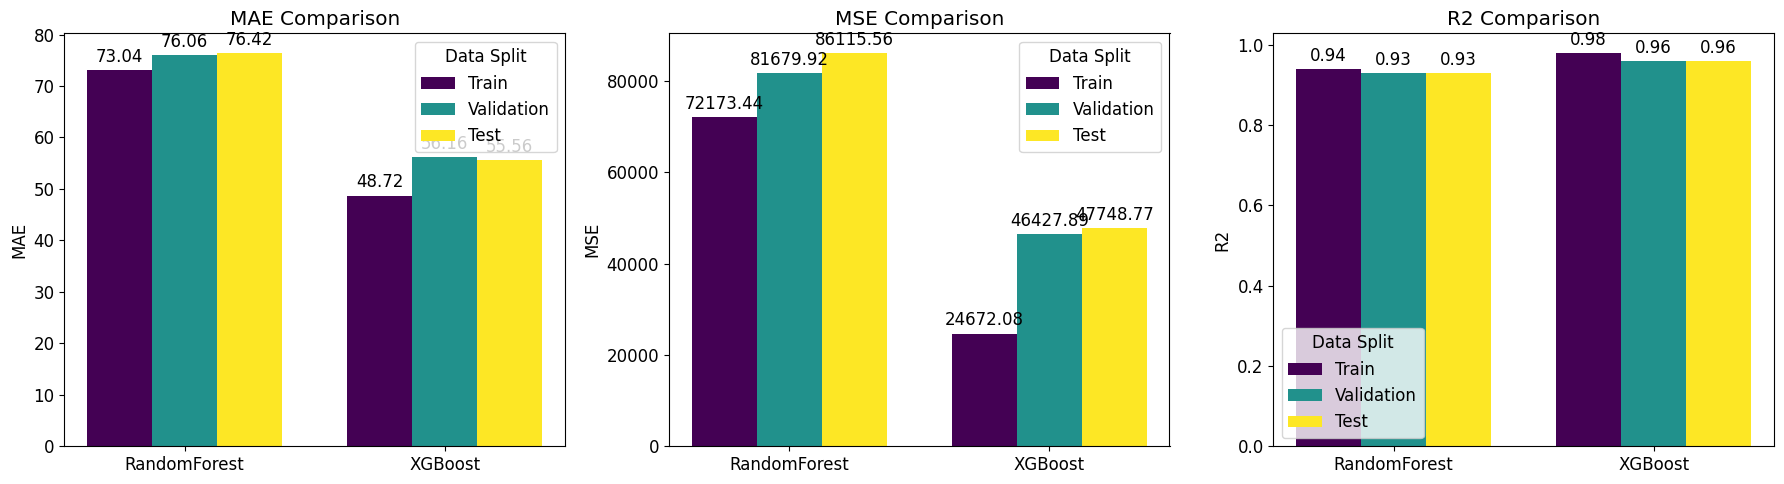

In [ ]:
# Bar plot to compare metrics
metrics = ["MAE", "MSE", "R2"]
splits_order = ["Train", "Validation", "Test"]

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)
cmap = plt.get_cmap("viridis")
n = len(splits_order)
colors = [cmap(i/(n-1)) for i in range(n)]

for ax, metric in zip(axes, metrics):
    # Data for this metric: models × splits
    dfm = table.loc[metric].unstack(level=1).reindex(columns=splits_order)
    x = np.arange(len(dfm.index))
    width = 0.25

    for i, split in enumerate(splits_order):
        bars = ax.bar(x + i*width, dfm[split], width,
                      label=split, color=colors[i])
        # annotate each bar
        ax.bar_label(bars, padding=3, fmt="%.2f")

    ax.set_xticks(x + width, dfm.index)
    ax.set_title(f"{metric} Comparison")
    ax.set_ylabel(metric)
    ax.legend(title="Data Split")

fig.tight_layout()
plt.show()

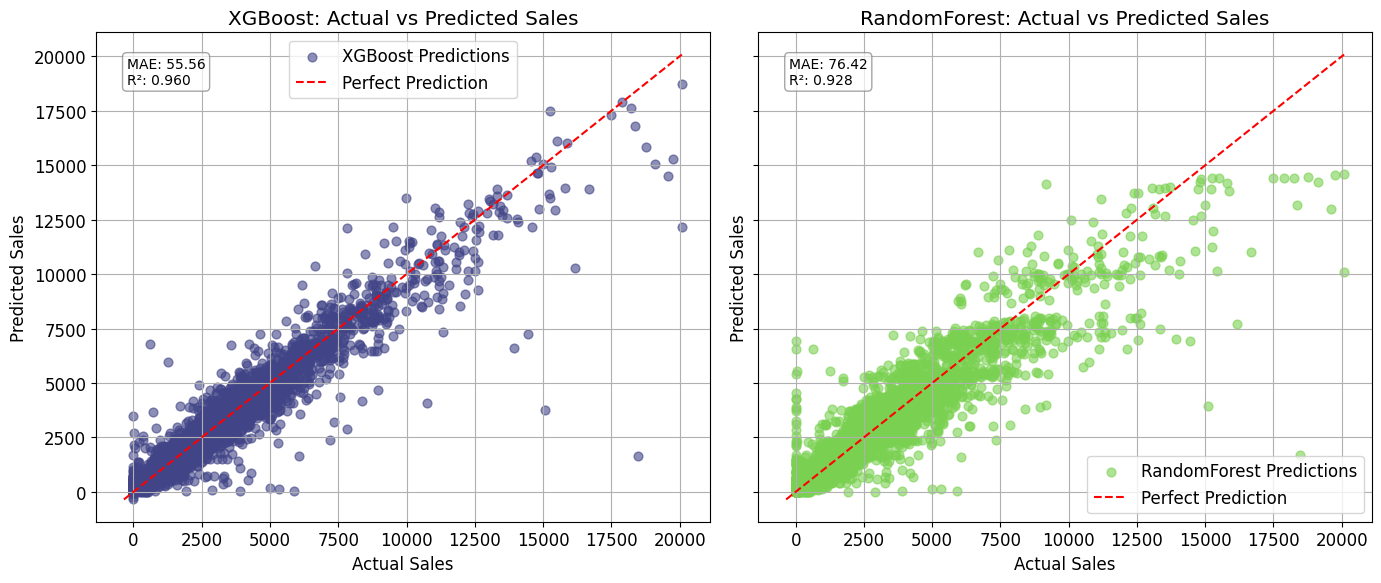

In [ ]:
# Actual vs Predicted Sales
X_test_data, y_test_data = X_test, y_test  # adjust if your variable names differ
models = {
    "XGBoost":      best_xgb,
    "RandomForest": best_rf,
}

# Get predictions
preds = {name: model.predict(X_test_data) for name, model in models.items()}

# Set up subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)
cmap = plt.get_cmap("viridis")
colors = [cmap(0.2), cmap(0.8)]  # pick two distinct viridis colors

# Determine common plot limits
all_actual = y_test_data
all_predicted = np.concatenate(list(preds.values()))
mn = min(all_actual.min(), all_predicted.min())
mx = max(all_actual.max(), all_predicted.max())

for ax, (name, y_pred), color in zip(axes, preds.items(), colors):
    # scatter
    ax.scatter(y_test_data, y_pred, alpha=0.6, s=40, color=color, label=f"{name} Predictions")
    # perfect-prediction line
    ax.plot([mn, mx], [mn, mx], linestyle="--", color="red", label="Perfect Prediction")

    # metrics
    mae = mean_absolute_error(y_test_data, y_pred)
    r2  = r2_score(y_test_data, y_pred)
    text = f"MAE: {mae:.2f}\nR²: {r2:.3f}"
    ax.text(
        0.05, 0.95, text,
        transform=ax.transAxes,
        fontsize=10,
        va="top",
        bbox=dict(facecolor="white", edgecolor="gray", alpha=0.7, boxstyle="round")
    )

    # labels & title
    ax.set_title(f"{name}: Actual vs Predicted Sales")
    ax.set_xlabel("Actual Sales")
    ax.set_ylabel("Predicted Sales")
    ax.grid(True)
    ax.legend()

# tighten & show
fig.tight_layout()
plt.show()

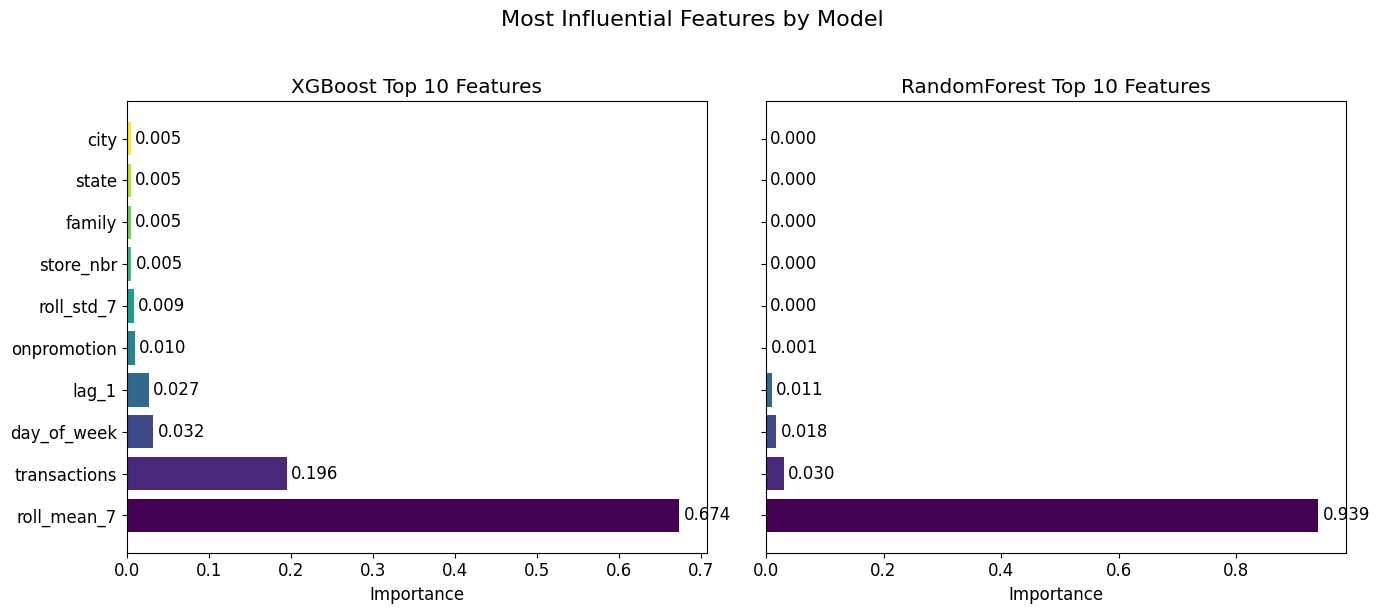

In [ ]:
# Identify the most influential features affecting the target variable
# Get feature names (all columns except the target 'sales')
feature_names = [c for c in data_sample.columns if c != "sales"]

# Trained models
models = {
    "XGBoost":      best_xgb,
    "RandomForest": best_rf,
}

# Number of top features to show
top_n = 10

# Extract & sort importances for each model
imps = {}
for name, model in models.items():
    vals   = model.feature_importances_
    series = pd.Series(vals, index=feature_names)
    imps[name] = series.sort_values(ascending=False).head(top_n)

# Plot side-by-side horizontal bars with viridis colormap
fig, axes = plt.subplots(1, len(models), figsize=(14, 6), sharey=True)
cmap   = plt.get_cmap("viridis")
colors = [cmap(i/(top_n-1)) for i in range(top_n)]

for ax, (name, imp_series) in zip(axes, imps.items()):
    # positions & bars
    y_pos = np.arange(len(imp_series))
    bars  = ax.barh(y_pos, imp_series.values, color=colors)

    # label each bar with its importance value
    ax.bar_label(bars, fmt="%.3f", padding=3)

    # set y-ticks to feature names and invert so the highest importance is at the top
    ax.set_yticks(y_pos)
    ax.set_yticklabels(imp_series.index)
    ax.invert_yaxis()

    # titles and grid
    ax.set_title(f"{name} Top {top_n} Features")
    ax.set_xlabel("Importance")

# overall title and layout
fig.suptitle("Most Influential Features by Model", fontsize=16, y=1.02)
fig.tight_layout()
plt.show()